# Assignment : P2

You can download the images and annotations for the Oxford Pets dataset from this website [https://www.robots.ox.ac.uk/~vgg/data/pets/](https://www.robots.ox.ac.uk/~vgg/data/pets/).

In [ ]:
from collections import namedtuple
import csv

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Conv2DTranspose, add as keras_add
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from PIL import Image, ImageOps

In [ ]:
PATH_TO_IMAGES = 'p_data/images'
PATH_TO_CLASS_LIST = 'p_data/annotations/list.txt'
PATH_TO_TRIMAPS = 'p_data/annotations/trimaps'


TARGET_SIZE = (224, 224)

In [ ]:
# We will be using this process on BOTH the input images and the trimaps.
def resize_image(path_to_image, target_size=None, pad_with_value=0):
    image = Image.open(path_to_image)
    width, height = image.size

    w_pad = 0
    h_pad = 0
    bonus_h_pad = 0
    bonus_w_pad = 0

    if width > height:
        pix_diff = (width - height)
        h_pad = pix_diff // 2
        bonus_h_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    elif height > width:
        pix_diff = (height - width)
        w_pad = pix_diff // 2
        bonus_w_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    # else: image is already square. Both pads stay 0

    image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad), pad_with_value)

    if target_size is not None:
        # Note, width and height have changed due to the padding resize.
        # Update our notions so we get the scale factor right
        width, height = image.size

        image = image.resize(target_size)

        width_scale = target_size[0] / width
        height_scale = target_size[1] / height

    # This is a change, this function now handles data with either 1 or 3 color
    # channels. We can detect this from the shape of the np.array so we've broken
    # this line into 3.
    image_as_array = np.array(image.getdata())
    if len(image_as_array.shape) == 2:
        # This is required to handle transparency, which some of the JPGs contain.
        # We are essentially removing the alpha channel.
        if image_as_array.shape[1] == 4:
            image_as_array = image_as_array[:, 0:3]
        image_data = image_as_array.reshape(image.size[0], image.size[1], 3)
    else:
        image_data = image_as_array.reshape(image.size[0], image.size[1])

    # Image data is a 3D array, 3 channels (RGB) of target_size.
    # RBG values are from 0-255. Later in this notebook we preprocess
    # those images with the MobileNetV2 preprocess input function.
    return image_data

In [ ]:
# Given a reshaped trimap, reduce it such that it contains
# 2 values: 0 for "not object of interest" and 1 for "object of interest"

# Note that, this transform includes the "unclassified" border zone
# as part of the background. If you wanted to explicitly classify
# the border seprately from the image you'd have to make this transform
# more involved, and not reduce the trimap to jsut values.

# Similarly, if you had examples with dogs and cats in the same image
# This reduction step would have to account for those values differently
def reduce_trimap_values(trimap):
    return np.where((trimap == 1), 1, 0)

In [ ]:
# Given the relevant data from a row of the CSV return a reshaped image
# as well the reshaped trimap
def prepare_sample_from_name(sample_name):
    path_to_image = os.path.join(PATH_TO_IMAGES, sample_name + '.jpg')
    path_to_trimap = os.path.join(PATH_TO_TRIMAPS, sample_name + '.png')

    image_data = resize_image(path_to_image, TARGET_SIZE)

    # Note that in OUR TRIMAPS 1 is the value for "background"
    # The final value of 2 is specific to our dataset!!
    trimap = resize_image(path_to_trimap, TARGET_SIZE, 2)

    return (image_data, trimap)

In [ ]:
# Plot just the image, or just the trimap, by leaving them none.
# If both are specified the trimap will be printed on top of the image
# in a semi-transparent way. I love how easy this one is.
def plot_with_trimap_overlay(image=None, trimap=None):
    if image is not None:
        plt.imshow(image)

    if trimap is not None:
        plt.imshow(trimap, alpha=.5)

    plt.colorbar()
    plt.show()


(224, 224, 3) (224, 224)


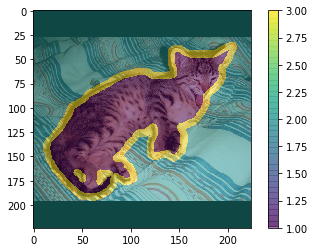

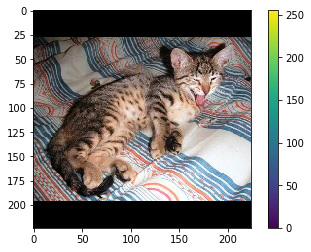

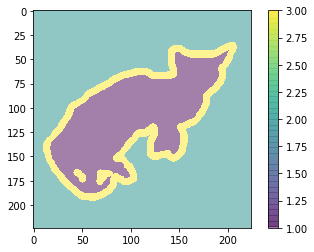

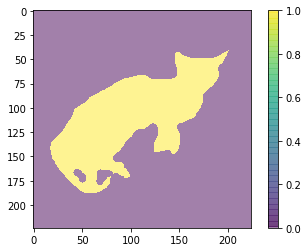

In [ ]:
# functions testing
sample_name = 'Egyptian_Mau_219'
image, trimap = prepare_sample_from_name(sample_name)

print(image.shape, trimap.shape)

plot_with_trimap_overlay(image, trimap)
plot_with_trimap_overlay(image=image)
plot_with_trimap_overlay(trimap=trimap)
plot_with_trimap_overlay(trimap=reduce_trimap_values(trimap))

In [ ]:
# Processing all our samples. After this we'll prepare the
# data and labels for our network and perform a validation split.
processed_data = []

# Processing all this data takes some time...
# Took my laptop roughly 8 minutes
with open(PATH_TO_CLASS_LIST) as csv_list_file:
    csv_reader = csv.reader(csv_list_file, delimiter=' ')

    for row in csv_reader:
        if row[0].startswith('#'): continue

        # Unpack for readability
        sample_name, class_id, species, breed_id = row

        # Not every image has a bounding box, some files are missing.
        # Use a try/except block to ignore such samples
        try:
            image, trimap = prepare_sample_from_name(sample_name)
        except FileNotFoundError:
            # More images have their trimap than had their bounding box
            # which is a small surprise.
            print(f'No annotations for {sample_name}: skipped.')
            continue

        # species - 1 so cat = 0 and dog = 1.
        # Makes things a little easier to process
        data_tuple = (image, int(species) - 1, trimap)
        processed_data.append(data_tuple)

print(f'Processed {len(processed_data)} samples')

# Make it a numpy array
processed_data = np.array(processed_data)

Processed 7349 samples


5503 dog


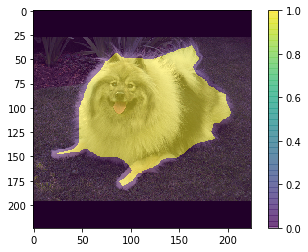

1424 dog


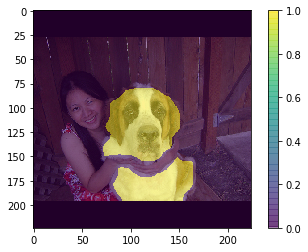

5258 dog


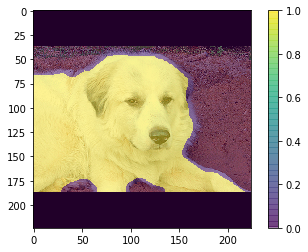

154 dog


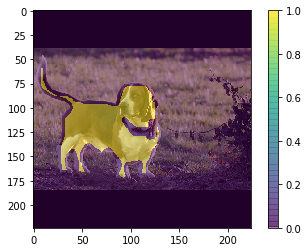

933 dog


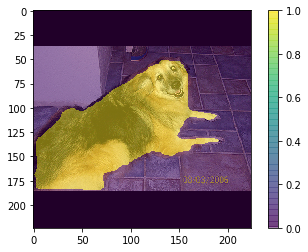

In [ ]:
# Checking random spots
for _ in range(5):
    i = np.random.randint(len(processed_data))
    image, species, trimap = processed_data[i]

    if species == 0:
        print(i, "cat")
    elif species == 1:
        print(i, "dog")
    else:
        print("ERROR DETECTED: Invalid species type")

    plot_with_trimap_overlay(image, reduce_trimap_values(trimap))

In [ ]:
sp = processed_data[:3000][:]

In [ ]:
# we're going to have the final output layer produce 3 activation maps
# One activation map each for the location of cats, dogs, and background

# In our dataset, for the true labels, one of these panes will always
# be empty (all 0), because our dataset never has images with a cat and
# a dog in the same image.

# We'll test our network afterwards on a few images with both
# dogs and cats, and see what happens
x_train = []
y_train = []

x_validation = []
y_validation = []

validation_split = 0.2

# Notice that we're applying the preprocess_input function to the images here.
# Also note that our labels are shaped (w, h, 3), one pane each for "cat, dog, background"
for image, species, trimap in sp:
    processed_image = preprocess_input(image)

    # 3 panes each with binary values. Note they mutually exclusive, each pixel can be "on"
    # in exactly ONE of the three following maps.
    cat_segmentation = reduce_trimap_values(trimap) if species == 0 else np.zeros(trimap.shape)
    dog_segmentation = reduce_trimap_values(trimap) if species == 1 else np.zeros(trimap.shape)
    bg_segmentation = np.logical_not(reduce_trimap_values(trimap))

    if np.random.random() > validation_split:
        x_train.append(processed_image)
        y_train.append([cat_segmentation, dog_segmentation, bg_segmentation])
    else:
        x_validation.append(processed_image)
        y_validation.append([cat_segmentation, dog_segmentation, bg_segmentation])

x_train = np.array(x_train)
y_train = np.array(y_train)

x_validation = np.array(x_validation)
y_validation = np.array(y_validation)

# Because of how we appeneded the cat and dog data to the labels
# we need to change the dimensions before prediction so that the
# color channels are where the network expects them:
y_train = np.rollaxis(y_train, 1, 4)
y_validation = np.rollaxis(y_validation, 1, 4)

(224, 224, 3) (224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


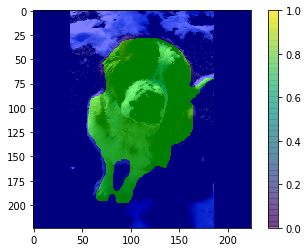

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3) (224, 224, 3)


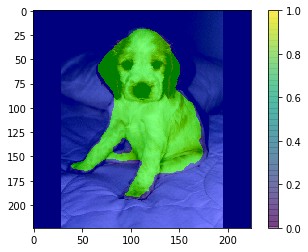

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3) (224, 224, 3)


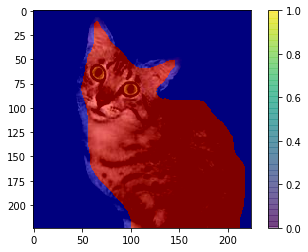

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3) (224, 224, 3)


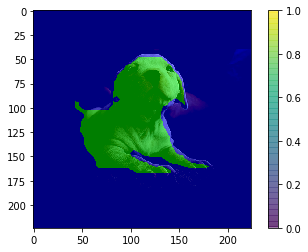

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3) (224, 224, 3)


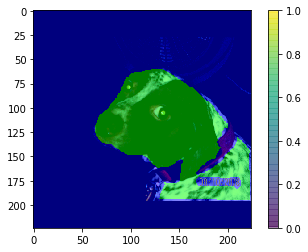

In [ ]:
# Checking
for _ in range(5):
    i = np.random.randint(len(x_train))
    image = x_train[i]
    label = y_train[i]

    # Note that it is coincidence that these are the same shape!!!
    # The image is 3 color channels, the label is 3 classes (cat, dog, background)
    # The result is R = cat, G = dog, B = background when using imshow
    print(image.shape, label.shape)
    plot_with_trimap_overlay(image, label)

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# We're going to lop off the last few layers, which have most
# likely learned the highest level features specific to imagenet
chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])

# Now, we have to use "Convolution Transpose" sometimes called "Deconvolution" to
# re-increase the resolution, since MobileNetV2 significantly reduces the input size
# Drawing on inspiration from U-Net, we're also going to add some symmetric skip connections
# which should make us feel *very* fancy.
segmentation_output = Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(chopped_mobilenet.output)

segmentation_output = Conv2DTranspose(24, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(
    keras_add([segmentation_output, base_model.layers[45].output])
)

segmentation_output = Conv2DTranspose(24, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(
    keras_add([segmentation_output, base_model.layers[27].output])
)

# Note: we use 3 frames, one for cat one for dog one for background, and we
# and likely improve our result, especially with respect to generalization and finding
# BOTH cats and dogs in the same image. Plus, it would allow us to detect the absense
# of either cats or dogs more readily.
segmentation_output = Conv2DTranspose(3, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='softmax')(segmentation_output)

model = Model(inputs=[chopped_mobilenet.input], outputs=[segmentation_output])

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

model.fit(x_train, y_train,
          validation_data=(x_validation, y_validation),
          epochs=10,
          verbose=True
)

Epoch 1/10
76/76 [==============================] - 440s 6s/step - loss: 0.4976 - accuracy: 0.7880 - val_loss: 1.0242 - val_accuracy: 0.7940
Epoch 2/10
76/76 [==============================] - 368s 5s/step - loss: 0.2807 - accuracy: 0.8798 - val_loss: 1.0841 - val_accuracy: 0.7875
Epoch 3/10
76/76 [==============================] - 357s 5s/step - loss: 0.2430 - accuracy: 0.8959 - val_loss: 1.1164 - val_accuracy: 0.7993
Epoch 4/10
76/76 [==============================] - 320s 4s/step - loss: 0.1823 - accuracy: 0.9298 - val_loss: 0.9746 - val_accuracy: 0.8208
Epoch 5/10
76/76 [==============================] - 317s 4s/step - loss: 0.1533 - accuracy: 0.9422 - val_loss: 1.0163 - val_accuracy: 0.8246
Epoch 6/10
76/76 [==============================] - 319s 4s/step - loss: 0.1341 - accuracy: 0.9497 - val_loss: 1.2928 - val_accuracy: 0.8193
Epoch 7/10
76/76 [==============================] - 318s 4s/step - loss: 0.1213 - accuracy: 0.9536 - val_loss: 1.3670 - val_accuracy: 0.8219
Epoch 8/10
76

True Label


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


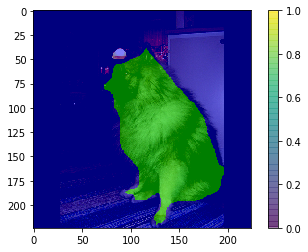

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction


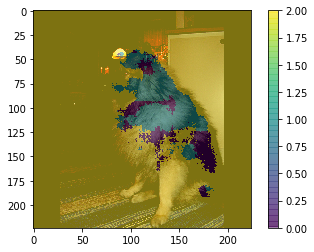

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label


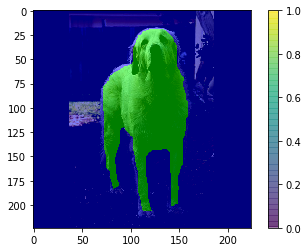

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction


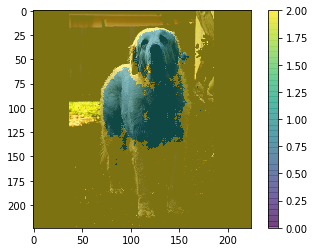

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label


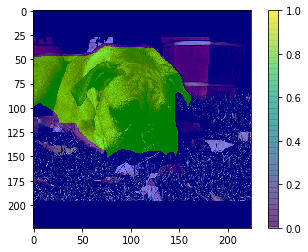

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction


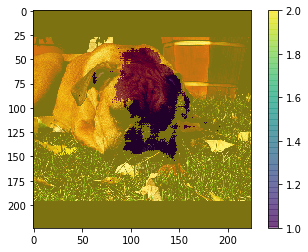

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label


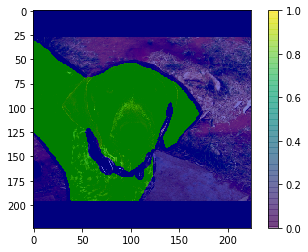

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction


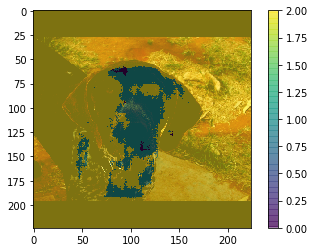

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label


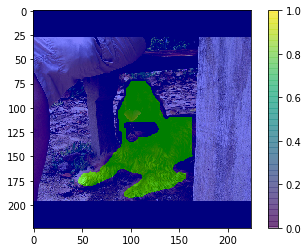

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction


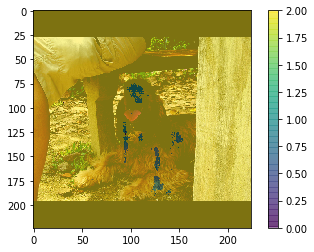

In [ ]:
for _ in range(5):
    i = np.random.randint(len(y_validation))
    img = x_validation[i]
    label = y_validation[i]
    pred = model.predict(np.array([img]))

    pred_panes = pred[0]
    pred_panes_maxed = np.argmax(pred_panes, axis=2)


    print("True Label")
    plot_with_trimap_overlay(img, label)

    print("Prediction")
    plot_with_trimap_overlay(img, pred_panes_maxed)